# TF-IDF models

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# load dataset

In [12]:
df = pd.read_csv('../FINAL_GEMINI_CHATGPT_FULL_fixed_20250602_230757.csv')
print(len(df))

# # only when you want to use advers as validation
# df = pd.read_csv('../FINAL_GEMINI_CHATGPT_DEFAULT_fixed_20250602_230832.csv')
# advers_df = pd.read_csv('../FINAL_GEMINI_CHATGPT_ADVERS_fixed_20250602_230658.csv')
# print(len(advers_df))

50000


In [13]:
def split_dataframe_by_document_ids(df, test_size=0.2):
    """
    Split dataframe into train and validation sets ensuring documents stay together.
    """
    # Get unique document IDs and calculate split
    unique_ids = set(df['document_id'])
    num_test_docs = int(len(unique_ids) * test_size)
    
    # Randomly select test documents
    test_ids = np.random.choice(list(unique_ids), size=num_test_docs, replace=False)
    
    # Split dataframe
    val_df = df[df['document_id'].isin(test_ids)].copy()
    train_df = df[~df['document_id'].isin(test_ids)].copy()
    
    print(f"Unique documents: {len(unique_ids)}")
    print(f"Test documents: {len(test_ids)}")
    print(f"Test set size: {len(val_df)}")
    print(f"Training set size: {len(train_df)}")
    
    return train_df, val_df

def split_dataframe_by_model(df, test_size=0.2, model_name='chatgpt'):
    # Get unique document IDs and calculate split
    unique_ids = set(df['document_id'])
    num_test_docs = int(len(unique_ids) * test_size)
    
    # Randomly select test documents
    test_ids = np.random.choice(list(unique_ids), size=num_test_docs, replace=False)
    
    # Split dataframe
    val_df = df[df['document_id'].isin(test_ids)].copy()
    val_df = val_df[val_df['source'] != model_name]
    train_df = df[~df['document_id'].isin(test_ids)].copy()
    train_df = train_df[train_df['source'] == model_name]
    print(f"Unique documents: {len(unique_ids)}")
    print(f"Test documents: {len(test_ids)}")
    print(f"Test set size: {len(val_df)}")
    print(f"Training set size: {len(train_df)}")
    return train_df, val_df

def split_dataframe_by_prompt(df, test_size=0.2, task='rephrase'):
    # Get unique document IDs and calculate split
    unique_ids = set(df['document_id'])
    num_test_docs = int(len(unique_ids) * test_size)
    
    # Randomly select test documents
    test_ids = np.random.choice(list(unique_ids), size=num_test_docs, replace=False)
    
    # Split dataframe
    val_df = df[df['document_id'].isin(test_ids)].copy()
    val_df = val_df[val_df['task'] == task]
    train_df = df[~df['document_id'].isin(test_ids)].copy()
    train_df = train_df[train_df['task'] != task]
    print(f"Unique documents: {len(unique_ids)}")
    print(f"Test documents: {len(test_ids)}")
    print(f"Test set size: {len(val_df)}")
    print(f"Training set size: {len(train_df)}")
    return train_df, val_df

# Split the data by document ids / model / prompt
train_df, val_df = split_dataframe_by_document_ids(df)
# Or use your own split
# train_df =df
# val_df = advers_df

Unique documents: 3257
Test documents: 651
Test set size: 10113
Training set size: 39887


In [14]:
# Create lists of texts and corresponding labels
train_texts = train_df['chapter'].tolist() + train_df['generated'].tolist()
train_labels = [0] * len(train_df) + [1] * len(train_df)

val_texts = val_df['chapter'].tolist() + val_df['generated'].tolist()
val_labels = [0] * len(val_df) + [1] * len(val_df)

In [6]:
print(len(train_texts))
print(len(val_texts))
print(len(train_labels))
print(len(val_labels))


80022
19978
80022
19978


In [15]:
def truncate_texts(texts, max_length=4*128):
    return [text[:max_length] for text in texts]

# Apply truncation to both training and validation texts
train_texts = truncate_texts(train_texts)
val_texts = truncate_texts(val_texts)

# Create TF-IDF vectorizer

In [16]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)

## Logistic Regression 

In [17]:
# Train a logistic regression model
tfidf_model = LogisticRegression()

# Fit the model
tfidf_model.fit(X_train_tfidf, train_labels)

# Make predictions
train_predictions = tfidf_model.predict(X_train_tfidf)
val_predictions = tfidf_model.predict(X_val_tfidf)


## Random Forest 

In [28]:
# Train a random forest model
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(
    random_state=42,
    verbose=1,
    n_jobs=6
)

rf_model.fit(X_train_tfidf, train_labels)


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  2.7min finished


RandomForestClassifier(n_jobs=6, random_state=42, verbose=1)

In [29]:

# Make predictions
# train_predictions = rf_model.predict(X_train_tfidf)
val_predictions = rf_model.predict(X_val_tfidf)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    2.1s finished


## Evaluate the predictions

In [18]:
# Calculate accuracy
train_accuracy = accuracy_score(train_labels, train_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)
val_f1_score = f1_score(val_labels, val_predictions)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"f1 score: {val_f1_score:.4f}")

# Print classification report
print("\nClassification Report for Validation Set:")
print(classification_report(val_labels, val_predictions))



Training Accuracy: 0.9018
Validation Accuracy: 0.8624
f1 score: 0.8588

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     10113
           1       0.88      0.84      0.86     10113

    accuracy                           0.86     20226
   macro avg       0.86      0.86      0.86     20226
weighted avg       0.86      0.86      0.86     20226



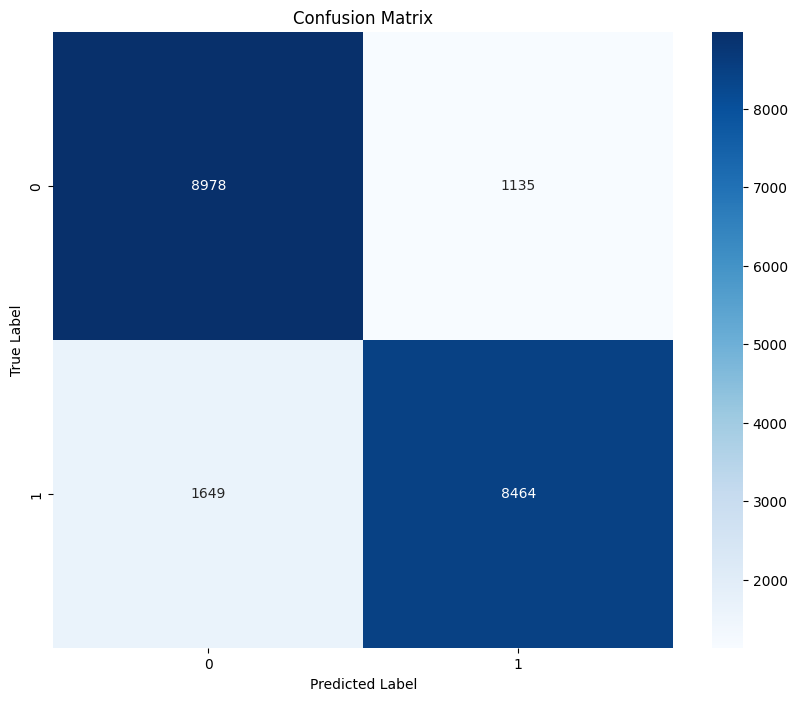

[[8978 1135]
 [1649 8464]]


In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(cm)

In [ ]:
# Get feature importance
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = tfidf_model.coef_[0]

# Get top features for each class
n_top_features = 30
top_indices = coefficients.argsort()[-n_top_features:][::-1]
bottom_indices = coefficients.argsort()[:n_top_features]

print("\nTop features for AI-generated text:")
for idx in top_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

print("\nTop features for original text:")
for idx in bottom_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")



Top features for AI-generated text:
precum: 13.1206
adesea: 10.2173
esențial: 10.1558
această: 9.2771
deși: 8.9899
subliniază: 8.8642
rezumat: 8.4444
esențială: 8.3672
esențiale: 8.1152
textul: 7.7696
indică: 7.7390
special: 7.5776
semnificativ: 7.5754
și: 7.4220
crucial: 7.3268
diverse: 7.0160
inclusiv: 6.6957
incluzând: 6.5136
evidențiind: 6.5036
include: 6.4752
semnificativă: 6.4068
evidențiază: 6.3116
analizează: 6.2411
conform: 6.2193
principale: 6.0712
includ: 5.9741
contribuind: 5.8937
aceste: 5.8500
predominant: 5.7807
ci: 5.7622

Top features for original text:
este: -9.2127
care: -8.3048
respectiv: -7.8488
numai: -7.4740
si: -6.8131
privire: -6.6619
sunt: -6.0336
foarte: -6.0228
anume: -5.7992
presupune: -5.7861
vederea: -5.6755
multe: -5.2587
ȋn: -5.1991
privește: -5.1228
aceea: -4.7211
anul: -4.7041
constituie: -4.6400
ei: -4.3858
diferite: -4.3718
făcut: -4.2572
realizarea: -4.0732
există: -4.0529
ajutorul: -3.9564
au: -3.7807
in: -3.7618
serie: -3.7589
etc: -3.7379
colab